# Marijuana Sales Prediction

## Objective
- Find the most relevent features for total sales income. 

## Import Required Libraries

In [143]:
# Import system tools
import os 
import sys
import warnings

# import numerical tools
import numpy as np
import scipy as sp

# import dataframe tools
import pandas as pd

# import plotting packages
import seaborn as sns
import matplotlib.pyplot as plt

#===================Sci-kit Learn packages===================
# ML pipeline tools
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
# data preprocess tools (feature engineering)
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
# ML models
# linear models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
# tree model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
# support vector machine
from sklearn.svm import SVR 
# dimension reduction 
from sklearn.decomposition import PCA
# grid search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


## Load Data

In [144]:
%reload_ext autoreload
%autoreload 2
# turn-off pandas warnings
warnings.filterwarnings('ignore')

# Load Dataset
avgRetail = pd.read_csv("../data/BrandAverageRetailPrice.csv")
brandDetail = pd.read_csv("../data/BrandDetails.csv")
totalSales = pd.read_csv("../data/BrandTotalSales.csv")
totalUnits = pd.read_csv("../data/BrandTotalUnits.csv")

## Construct Dataset
- General Info (choose initial dataset)
- Construct time-series data
- EDA/Add new feature

### Total Sales Data
- This dataset has the featured directly related to out objective, and also it contains only few features. Above reasons make it a good starting point to construct our train/test data. 

In [145]:
totalSales.info()
totalSales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


### Organize Total Sales Data
- Convert "Months" feature into datetime format
- Convert Sales to data-type float 

In [146]:
# convert the time stamp dataset
totalSales["Months"] = totalSales["Months"].astype(str).astype('datetime64[ns]')
# convert salses data to numerical data form
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].str.replace(',','')
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].astype(float)
totalSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


### Lists to be analyzed brands
- Observation
    1. Total number of data has largest group locate in 37 data
    2. Ignore the brands that are lack of reported data
    3. Set the threshold to 37 data 

The largest group has 195 data
With current threshold, data information loss: 88.01%


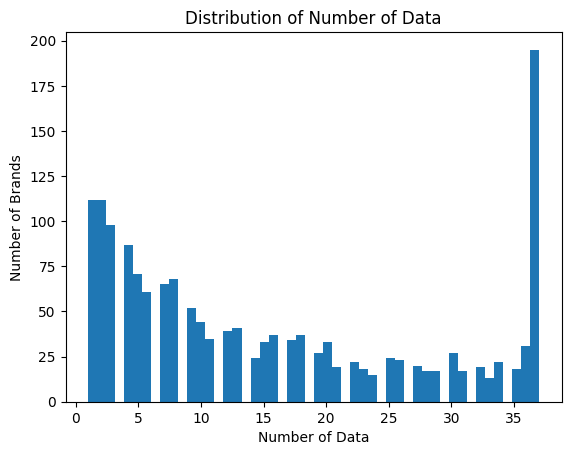

In [147]:
# Find the distribution of the #brand_data
numBrandData = pd.DataFrame()
numBrandData.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
numBrandData.loc[:, "brand_count"] = [1]*len(totalSales["Brand"])
# count each brand's total number of reported data
numBrandData = numBrandData.groupby(["Brand"]).sum()
fig, axis = plt.subplots(1, 1)
counts, edges, bars = axis.hist(numBrandData["brand_count"], bins=50)
plt.title("Distribution of Number of Data")
plt.xlabel("Number of Data")
plt.ylabel("Number of Brands")
print(f"The largest group has {counts[-1]:.0f} data")

# filter out lack-of data brands
dataThreshold = 37
infoLoss = 1 - (len(numBrandData[numBrandData.brand_count >= dataThreshold])/len(numBrandData))
print(f"With current threshold, data information loss: {infoLoss:.2%}")


### Construct Initial Dataset
- Initialize dataset through copying total sales data
- Group dataset by Brand
- Filtered out the brands that #data is under threshold

#### Filtered Brand List
- Find the list of brands that number of data is above threshold

In [148]:
brandList = pd.DataFrame()
brandList.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
brandList.loc[:, "Count"] = [1]*len(totalSales["Brand"])
brandList = brandList.groupby(by="Brand").sum()
brands = brandList[brandList.Count >= dataThreshold].index
print(len(brands))

195


#### Initialize each brands data in dictionary

In [150]:
# initialize data
brandsData = dict()
for brand in brands:
    brandsData[brand] = totalSales[totalSales.Brand == brand]

#### EDA Sales Features
- Explore Correlation: 
    - Previous month sales
    - 3 months rolling sales
    - 6 months rolling sales 
- Result
    - previous month sales (strong correlation)
    - 3 months rolling sales (strong correlation)
    - 6 months rolling sales (weak correlation)
- Action
    - Adding "Previous Month Sales" & "3 months rolling sales" as new feature. 

In [221]:
# Calculate correlation between sales data
prevMonth_cor = []
roll3Month_cor = []
roll6Month_cor = []

for count, brand in enumerate(brands):   

    curSale = brandsData[brand].loc[:,"Total Sales ($)"]
    #==============add last month data===============================================
    prevSale = brandsData[brand].loc[:,"Total Sales ($)"].shift(-1)

    #===========Adding Rolling Sales Data===========
    # add rolling sales data (for three months)
    # calcualte the sum
    rollSum, rollMonths = 0, 3
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    roll3MonthSale = rollSum / rollMonths
    roll3MonthSale = roll3MonthSale[~np.isnan(roll3MonthSale)]

    # add rolling sales data (for six months)
    rollSum, rollMonths = 0, 6
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    roll6MonthSale = rollSum / rollMonths
    roll6MonthSale = roll6MonthSale[~np.isnan(roll6MonthSale)]

    cor2 = np.corrcoef(curSale[:len(roll3MonthSale)], roll3MonthSale)
    roll3Month_cor.append(cor2[1][0])
    
    cor3 = np.corrcoef(curSale[:len(roll6MonthSale)], roll6MonthSale)
    roll6Month_cor.append(cor3[1][0])

In [224]:
# find out not-correlation percentage
roll3_perc = np.sum(np.isnan(roll3Month_cor)) / len(roll3Month_cor)
roll6_perc = np.sum(np.isnan(roll6Month_cor)) / len(roll6Month_cor)
print(f"3 months rolling vs Previous has {roll3_perc:.2%} completely not correlated")
print(f"6 months rolling vs Previous has {roll6_perc:.2%} completely not correlated")

3 months rolling vs Previous has 0.00% completely not correlated
6 months rolling vs Previous has 0.00% completely not correlated


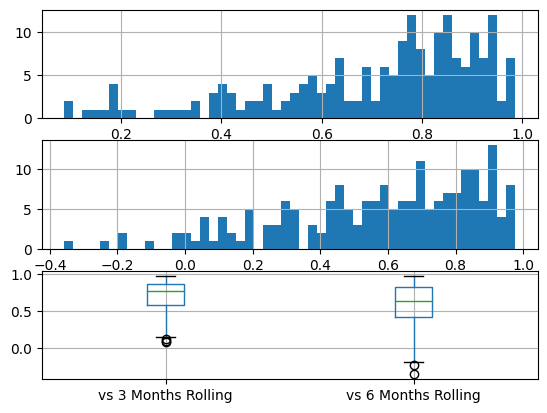

In [226]:
sales_cor = pd.DataFrame()
sales_cor.loc[:, "vs 3 Months Rolling"] = roll3Month_cor 
sales_cor.loc[:, "vs 6 Months Rolling"] = roll6Month_cor 

fig, axis = plt.subplots(3, 1, figsize=(20, 12))
sales_cor["vs 3 Months Rolling"].hist(bins=50, ax=axis[0])
sales_cor["vs 6 Months Rolling"].hist(bins=50, ax=axis[1])
sales_cor.boxplot(ax=axis[2])
plt.show()

#### Adding Sales Features

In [153]:
# construct all brands data
for brand in brands:   
    #==============add last month data===============================================
    brandsData[brand].loc[:, 'Previous Month Sales'] = brandsData[brand].loc[:,"Total Sales ($)"].shift(-1)

    #===========Adding Rolling Sales Data===========
    # add rolling sales data (for three months)
    # calcualte the sum
    rollSum, rollMonths = 0, 3
    for month in range(1, rollMonths + 1): 
        rollSum += brandsData[brand].loc[:,"Total Sales ($)"].shift(-1 * month)
    brandsData[brand].loc[:, 'Rolling Sales (3 months)'] = rollSum / rollMonths


In [216]:
brandsData["710 Labs"].corr()

,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months)
Total Sales ($),1.000000,0.599832,0.582142,0.378613
Previous Month Sales,0.599832,1.000000,0.813747,0.588912
Rolling Sales (3 months),0.582142,0.813747,1.000000,0.855612
Rolling Sales (6 months),0.378613,0.588912,0.855612,1.000000


## Data Preprocess
- Create pipeline (preprocessing)
- Hyper-parameters 
- Split dataset

## Deploy ML
- Linear Model
- Tree's Model
- Bagging and Boosting
- Neural Network

## Conclusion 
- Training/Testing result 
    1. Score
- Discussion
    1. Recommended action